# Conversion of Jump-start R program provided by Dr. Thomas Miller.

## Applied the Monte Carlo Simulation Method to a Personal ETF portfolio optimization problem. The Sharpe Ratio and target weights between the two schemes, Long Only and Shorts OK, have been compared

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

In [18]:
# Calculate covariance Matrix from given standard deviation and correlation matrix

def cov_from_sd_corr(sd, corr):
    """Build covariance matrix from SD vector and correlation matrix."""
    print(f"Input 1: SD array:\n {sd}")
    print(f"Input 2: Correlation Matrix:\n {corr}")
    D = np.diag(sd)
    print (f"Diagonal Matix D created from SD:\n {D}")
    print (f"first step calculate: D @ corr: \n {D @ corr}")
    return D @ corr @ D


In [19]:
def make_weights(n_assets, shorts_ok=True, rng=None, pareto_weights=None, std_dev=0.05):
    """Return a single weight vector that sums to 1.
       If pareto_weights is provided, use them as means for normal distribution sampling.
       Each asset's weight is sampled from N(pareto_weight[i], std_dev).
       
    Args:
        n_assets: Number of assets in portfolio
        shorts_ok: If True, allow negative weights (short positions)
        rng: Random number generator
        pareto_weights: Array of Pareto optimal weights to use as means for each asset (default: None)
        std_dev: Standard deviation for normal distribution around each Pareto weight (default: 0.05)
    """
    if rng is None:
        rng = np.random
    
    # Case 1: Use Pareto weights as mean for normal distribution (each asset separately)
    if pareto_weights is not None:
        pareto_weights = np.array(pareto_weights)
        
        if len(pareto_weights) != n_assets:
            raise ValueError(f"pareto_weights length ({len(pareto_weights)}) must match n_assets ({n_assets})")
        
        if shorts_ok:
            # Sample each weight from N(pareto_weight[i], std_dev)
            weights = rng.normal(loc=pareto_weights, scale=std_dev, size=n_assets)
            # Normalize to sum to 1
            weights = weights / weights.sum()
        else:
            # Sample from normal distribution, truncated at 0 (no shorts)
            weights = rng.normal(loc=pareto_weights, scale=std_dev, size=n_assets)
            # Clip negative values to 0 (no short positions allowed)
            weights = np.maximum(weights, 0)
            # Normalize to sum to 1
            if weights.sum() > 0:
                weights = weights / weights.sum()
            else:
                # Fallback if all weights are negative: use pareto weights directly
                weights = np.maximum(pareto_weights, 0)
                weights = weights / weights.sum() if weights.sum() > 0 else np.ones(n_assets) / n_assets
    
    # Case 2: Original uniform distribution sampling (no Pareto guidance)
    else:
        if shorts_ok:
            # Generate n-1 weights, then calculate the last one
            first_n_minus_1 = rng.uniform(-1, 1, size=n_assets-1)
            last_weight = 1.0 - first_n_minus_1.sum()
            weights = np.concatenate([first_n_minus_1, [last_weight]])
        else:
            raw = rng.uniform(0, 1, size=n_assets)
            weights = raw / raw.sum()
    
    return weights

In [20]:
def simulate_returns(mu, cov, sample_size=700, seed=None):
    """Simulate multivariate normal returns (sample_size x n_assets)."""
    rng = np.random.default_rng(seed)
    return rng.multivariate_normal(mean=mu, cov=cov, size=sample_size)

In [21]:
def evaluate_portfolios(returns, weights_matrix, cov_matrix, rf=0.0):
    """Compute portfolio return series, mean, sd, Sharpe, CVaR (95) for each weight set."""
    n_portfolios = weights_matrix.shape[0]
    n_assets = weights_matrix.shape[1]  # FIX: Get number of assets dynamically
    results = []
    
    for i in range(n_portfolios):
        w = weights_matrix[i]
        port_returns = returns @ w  # shape (T,)
        mean_ret = port_returns.mean()
        sd_ret = port_returns.std(ddof=1)
        sharpe = (mean_ret - rf) / sd_ret if sd_ret > 0 else np.nan
        # VaR (5% quantile) and CVaR (average of losses <= VaR)
        var_95 = np.percentile(port_returns, 5)
        cvar_95 = port_returns[port_returns <= var_95].mean() if np.any(port_returns <= var_95) else var_95
        # theoretical sigma via w' Sigma w as cross-check
        theo_sd = np.sqrt(w.T @ cov_matrix @ w)
        
        # FIX: Create weight dictionary dynamically
        weight_dict = {f"w{j+1}": w[j] for j in range(n_assets)}
        
        result = {
            **weight_dict,  # Unpack all weights
            "has_shorts": int(np.any(w < 0)),
            "mean": mean_ret,
            "sd_sample": sd_ret,
            "sd_theoretical": theo_sd,
            "sharpe": sharpe,
            "var_95": var_95,
            "cvar_95": cvar_95
        }
        results.append(result)
    return pd.DataFrame(results)

In [22]:
def run_experiment(mu, sd, corr, sample_size=700, n_weights=700, 
                   seed_returns=1111, seed_weights=9999, 
                   pareto_weights=None, use_pareto_guided=True, std_dev=0.05):
    """Run Monte Carlo: simulate returns, generate weight sets (shorts and no-shorts),
       evaluate portfolios and return combined results for both regimes.
    
    Args:
        mu: Expected returns array
        sd: Standard deviations array
        corr: Correlation matrix
        sample_size: Number of return samples to simulate
        n_weights: Number of portfolio weight combinations to generate
        seed_returns: Random seed for return simulation
        seed_weights: Random seed for weight generation
        pareto_weights: Array of Pareto optimal weights (one per asset) to guide sampling (default: None)
        use_pareto_guided: If True, use Pareto weights as guidance (default: True)
        std_dev: Standard deviation for normal distribution around each Pareto weight
    """
    n_assets = len(mu)
    
    cov = cov_from_sd_corr(sd, corr)
    returns = simulate_returns(mu, cov, sample_size=sample_size, seed=seed_returns)
    data_cov = np.cov(returns, rowvar=False)

    # Use Pareto weights as guidance if provided and enabled
    pareto_guidance = pareto_weights if (use_pareto_guided and pareto_weights is not None) else None
    
    # Validate pareto_weights length if provided
    if pareto_guidance is not None:
        pareto_guidance = np.array(pareto_guidance)
        if len(pareto_guidance) != n_assets:
            print(f"⚠️  Warning: pareto_weights length ({len(pareto_guidance)}) doesn't match n_assets ({n_assets})")
            print(f"   Pareto weights will be ignored.")
            pareto_guidance = None
        else:
            print(f"✓ Using Pareto-guided sampling with {n_assets} asset weights")
            print(f"  Pareto weights: {pareto_guidance}")
            print(f"  Std dev: {std_dev}")

    # Generate weights with Pareto guidance
    rng = np.random.default_rng(seed_weights)
    weights_shorts = np.vstack([
        make_weights(n_assets, shorts_ok=True, rng=rng, 
                    pareto_weights=pareto_guidance, std_dev=std_dev) 
        for _ in range(n_weights)
    ])
    
    rng2 = np.random.default_rng(seed_weights)  # same seed to keep parallel structure
    weights_long = np.vstack([
        make_weights(n_assets, shorts_ok=False, rng=rng2, 
                    pareto_weights=pareto_guidance, std_dev=std_dev) 
        for _ in range(n_weights)
    ])

    # Evaluate long only
    res_long = evaluate_portfolios(returns, weights_long, data_cov)
    res_long["regime"] = "Long Positions Only"

    # Evaluate shorts ok
    res_shorts = evaluate_portfolios(returns, weights_shorts, data_cov)
    res_shorts["regime"] = "Shorts OK"

    # Attach sample statistics
    sample_stats = {
        "returns_sim_mean": returns.mean(axis=0),
        "returns_sim_sd": returns.std(axis=0, ddof=1),
        "data_cov_matrix": data_cov
    }
    return pd.concat([res_long, res_shorts], ignore_index=True), sample_stats

In [23]:
def plot_results(df, title=None):
    df_plot = df.copy()
    df_plot["sd"] = df_plot["sd_sample"]
    df_plot["mean_return"] = df_plot["mean"]
    df_plot["short_flag"] = df_plot["has_shorts"].map({0:"No Shorts", 1:"Has Shorts"})
    print("Counts of short_flag within each regime:")
    print(df_plot.groupby("regime")["short_flag"].value_counts())
    # add scenario label from caller: caller should add 'scenario' column
    color_map = {"No Shorts": "darkblue", "Has Shorts": "red"}
    g = sns.FacetGrid(df_plot, row="scenario", col="regime", height=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="sd", y="mean_return", hue="short_flag", s=20, palette=color_map, alpha=0.7)
    g.set_axis_labels("Risk: Standard Deviation of Portfolio Returns", "Return: Mean of Portfolio Returns")
    if title:
        plt.subplots_adjust(top=0.9); g.fig.suptitle(title)
    return g

Column structure sample: [('Adj Close', 'AAPL'), ('Adj Close', 'ABBV'), ('Adj Close', 'AMD'), ('Adj Close', 'AMZN'), ('Adj Close', 'AVGO'), ('Adj Close', 'CME'), ('Adj Close', 'COST'), ('Adj Close', 'FDIVX'), ('Adj Close', 'FXY'), ('Adj Close', 'GLD'), ('Adj Close', 'GOOG'), ('Adj Close', 'HD'), ('Adj Close', 'INTC'), ('Adj Close', 'KO'), ('Adj Close', 'META'), ('Adj Close', 'MSFT'), ('Adj Close', 'NVDA'), ('Adj Close', 'PEP'), ('Adj Close', 'PFE'), ('Adj Close', 'PG')]
Final price columns: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']


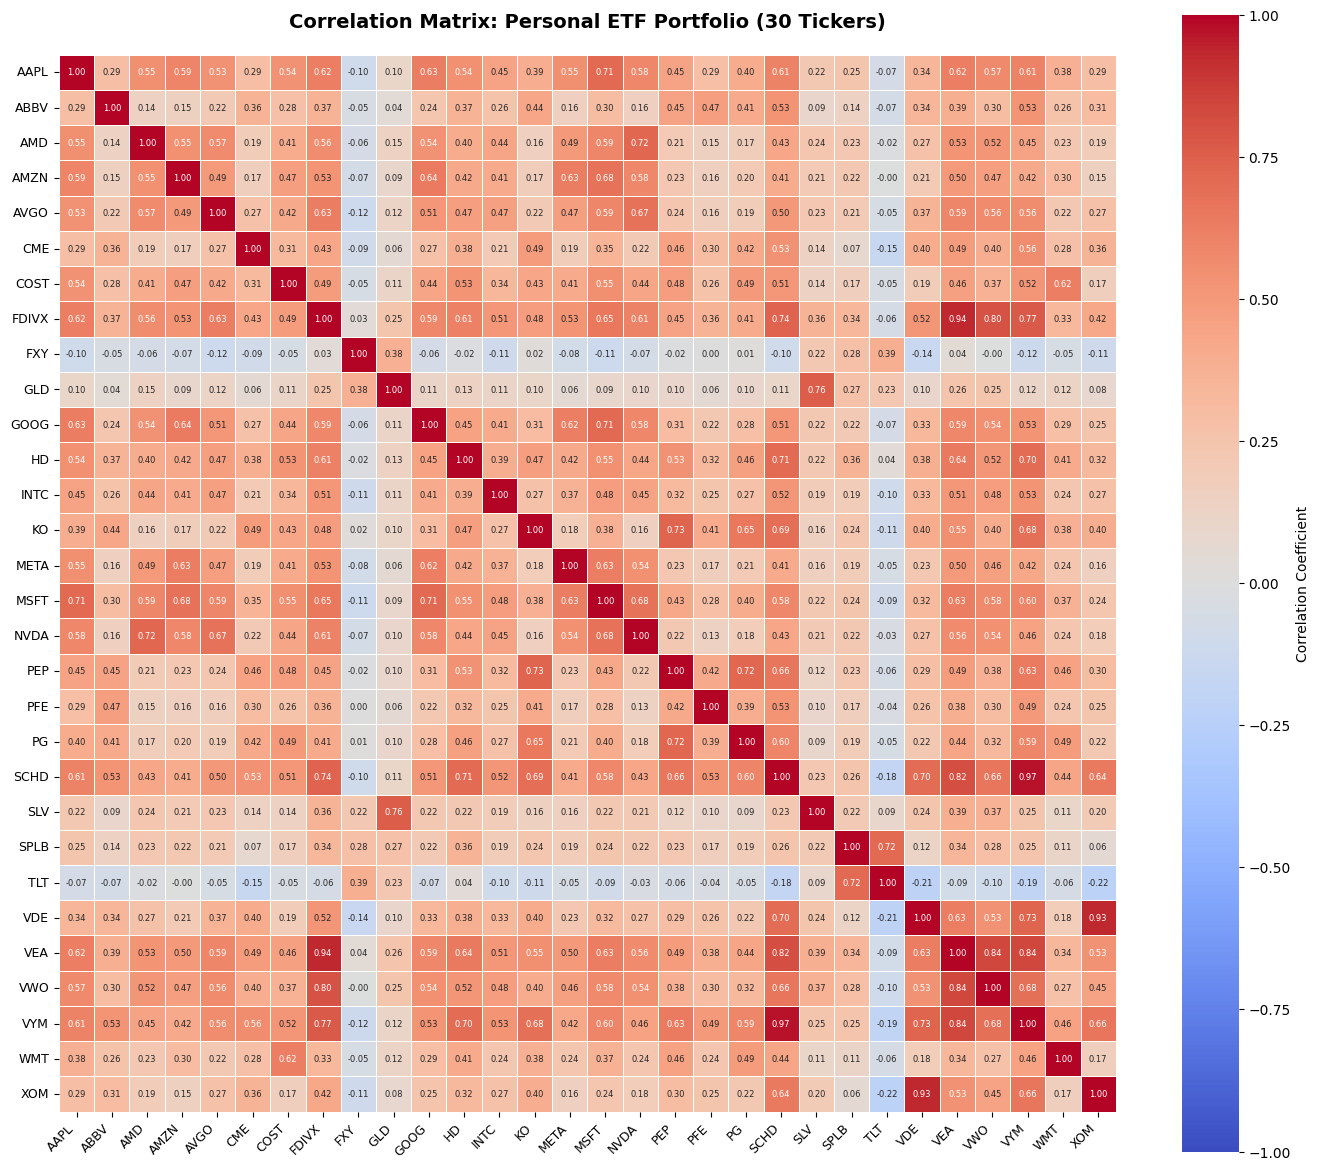

In [24]:
# -------------------------
# Scenario 1: Personal ETF
# -------------------------
import yfinance as yf
import pandas as pd

pareto_df = pd.read_csv("selected_portfolio_weights.csv")
tickers = pareto_df['Ticker'].tolist()
pareto_weights = pareto_df[pareto_df.columns[1]].tolist()

# date range for estimating parameters (at least 5 years recommended)
start_date = "2020-01-01"
end_date = "2025-10-31"
# try downloading (auto_adjust=False so "Adj Close" may appear)
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)

# inspect columns if something unexpected happens
print("Column structure sample:", list(data.columns[:20]))

# robust extraction of adjusted close prices
if isinstance(data.columns, pd.MultiIndex):
    # prefer level=0='Adj Close' if present, else try level=1
    if 'Adj Close' in data.columns.levels[0]:
        prices = data.xs('Adj Close', axis=1, level=0).dropna()
    elif 'Adj Close' in data.columns.levels[1]:
        prices = data.xs('Adj Close', axis=1, level=1).dropna()
    else:
        # fallback to 'Close' fields
        if 'Close' in data.columns.levels[0]:
            prices = data.xs('Close', axis=1, level=0).dropna()
        else:
            # flatten and attempt to pick ticker columns
            flat = pd.DataFrame({ (col[-1] if isinstance(col, tuple) else col): data[col] for col in data.columns })
            prices = flat.loc[:, flat.columns.intersection(tickers)].dropna()
else:
    # single-level columns: might already be tickers or 'Adj Close' absent
    if set(tickers).issubset(data.columns):
        prices = data.loc[:, tickers].dropna()
    elif 'Adj Close' in data.columns:
        prices = data['Adj Close'].dropna()
    else:
        # try any column containing 'Close'
        close_cols = [c for c in data.columns if 'Close' in str(c)]
        if close_cols:
            prices = data[close_cols].dropna()
        else:
            raise RuntimeError("Could not locate price columns in downloaded data; inspect data.columns")

# normalize column names to tickers (handles tuples)
prices.columns = [c if not isinstance(c, tuple) else c[-1] for c in prices.columns]
print("Final price columns:", list(prices.columns))

# compute daily simple returns
daily_ret = prices.pct_change().dropna()

# trading days per year (use 252 for US markets)
trading_days = 252

# Option A: arithmetic annualization (common, simple)
mean_daily = daily_ret.mean()
mu_annual = mean_daily * trading_days        # approximate expected annual return
sd_daily = daily_ret.std(ddof=1)
sd_annual = sd_daily * np.sqrt(trading_days) # annualized volatility

# correlation matrix (use daily returns)
corr_matrix = daily_ret.corr()

# convert to numpy arrays used by the notebook functions
mu2 = mu_annual.to_numpy()
sd2 = sd_annual.to_numpy()
corr2 = corr_matrix.to_numpy()

# Plot the correlation matrix as a seaborn heatmap with ticker labels
plt.figure(figsize=(14, 12))
sns.heatmap(corr2, 
            annot=True,           # CHANGED: Show correlation values
            fmt='.2f',            # ADDED: Format to 2 decimal places
            cmap='coolwarm',      # Color scheme (blue-red)
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Add gridlines
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1,      # Set scale from -1 to 1
            xticklabels=tickers,  # Use ticker names for x-axis
            yticklabels=tickers,  # Use ticker names for y-axis
            annot_kws={'fontsize': 6})  # ADDED: Smaller font for numbers

plt.title('Correlation Matrix: Personal ETF Portfolio (30 Tickers)', 
          fontsize=14, fontweight='bold', pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('correlation_matrix_heatmap_30tickers.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
pareto_df

,Ticker,333
0,AAPL,0.010123
1,ABBV,0.011440
2,AMD,0.000082
3,AMZN,0.000048
4,AVGO,0.010165
5,CME,0.096002
6,COST,0.010261
7,FDIVX,0.100893
8,FXY,0.000063
9,GLD,0.000075


In [26]:
res2, stats2 = run_experiment(mu2, sd2, corr2,
                              sample_size=700, n_weights=700,
                              seed_returns=2222, seed_weights=8888)

Input 1: SD array:
 [0.32183268 0.24962663 0.53897213 0.35734031 0.43644613 0.26898026
 0.23906935 0.19642579 0.10019433 0.16279062 0.32361967 0.28038329
 0.47339116 0.20440535 0.44240891 0.2978635  0.53583234 0.22301681
 0.27316618 0.20665819 0.1956416  0.31292405 0.15678102 0.17303574
 0.35220913 0.19651097 0.20873364 0.19204367 0.22991738 0.3314113 ]
Input 2: Correlation Matrix:
 [[ 1.00000000e+00  2.92602411e-01  5.47802965e-01  5.94929006e-01
   5.33169947e-01  2.90862554e-01  5.38369086e-01  6.24779185e-01
  -9.76766044e-02  1.04638623e-01  6.28910628e-01  5.42525449e-01
   4.48062577e-01  3.92898401e-01  5.53203993e-01  7.14415764e-01
   5.82945530e-01  4.46251498e-01  2.86069416e-01  4.02609826e-01
   6.06312173e-01  2.21649114e-01  2.47425057e-01 -6.80754252e-02
   3.44809798e-01  6.19557504e-01  5.73563839e-01  6.06575643e-01
   3.79470629e-01  2.92996342e-01]
 [ 2.92602411e-01  1.00000000e+00  1.42414618e-01  1.48950151e-01
   2.17414632e-01  3.62278311e-01  2.81004841e-01  

Counts of short_flag within each regime:
regime               short_flag
Long Positions Only  No Shorts     700
Shorts OK            Has Shorts    700
Name: count, dtype: int64


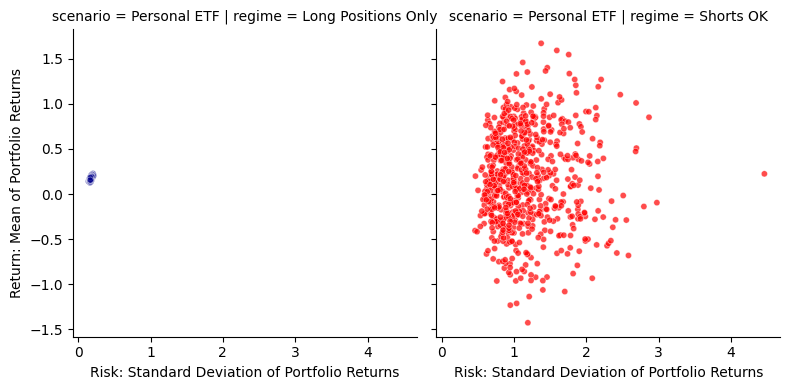

In [27]:
res2["scenario"] = "Personal ETF"
g = plot_results (res2)
g.savefig("portfolio_results_scenario2.png")

In [28]:
print("Top 10 portfolios by Sharpe Ratio:")
display(res2.sort_values(by="sharpe", ascending=False).head(10))

Top 10 portfolios by Sharpe Ratio:


,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w30,has_shorts,mean,sd_sample,sd_theoretical,sharpe,var_95,cvar_95,regime,scenario
747,-0.531499,0.875178,0.094141,-0.565186,0.145389,-0.680083,0.624449,-0.245971,-0.371348,0.404292,...,-0.356058,1,1.246659,0.841425,0.841425,1.481604,-0.193808,-0.451949,Shorts OK,Personal ETF
972,0.498354,-0.030256,-0.298665,-0.631747,0.980101,-0.846749,0.801021,0.206972,-0.435973,-0.733956,...,-0.210617,1,1.033468,0.733821,0.733821,1.408337,-0.136901,-0.479330,Shorts OK,Personal ETF
1051,-0.413078,0.436469,0.040492,-0.257400,-0.537335,-0.217620,0.957028,-0.838754,-0.095713,0.225205,...,0.472796,1,0.873113,0.636269,0.636269,1.372240,-0.147044,-0.412784,Shorts OK,Personal ETF
835,0.572706,0.757693,-0.223288,-0.004492,0.588392,-0.625719,0.268108,0.432066,0.283040,0.142572,...,0.639023,1,1.457982,1.120751,1.120751,1.300898,-0.406911,-0.840524,Shorts OK,Personal ETF
1323,-0.917342,0.012735,0.673742,-0.276873,0.801047,0.236842,-0.367694,-0.659932,-0.808201,-0.264728,...,-0.140899,1,1.330925,1.033564,1.033564,1.287704,-0.381568,-0.750140,Shorts OK,Personal ETF
941,0.653259,0.237137,0.371856,0.331535,0.113897,-0.775094,-0.920862,-0.097433,0.840927,0.966468,...,1.106583,1,0.819910,0.638045,0.638045,1.285036,-0.252879,-0.485460,Shorts OK,Personal ETF
1073,-0.650989,0.973078,0.342866,-0.057347,0.230940,0.014772,0.386084,0.624821,0.405850,0.488342,...,0.114013,1,0.761703,0.611190,0.611190,1.246263,-0.223338,-0.518014,Shorts OK,Personal ETF
774,-0.115452,0.849027,0.540767,-0.255153,0.766535,-0.216475,0.698212,-0.267648,-0.945918,0.249899,...,2.183672,1,1.156714,0.939239,0.939239,1.231545,-0.350886,-0.619372,Shorts OK,Personal ETF
780,-0.388531,0.340031,-0.590961,0.181948,0.737970,-0.125604,-0.806144,-0.134254,-0.380198,0.908426,...,1.089295,1,1.070140,0.879893,0.879893,1.216216,-0.335296,-0.671787,Shorts OK,Personal ETF
1000,0.334783,-0.654965,0.750100,-0.072096,0.155101,-0.011272,0.139932,0.299256,-0.915084,-0.007664,...,3.548808,1,1.669944,1.374928,1.374928,1.214568,-0.486826,-0.937291,Shorts OK,Personal ETF


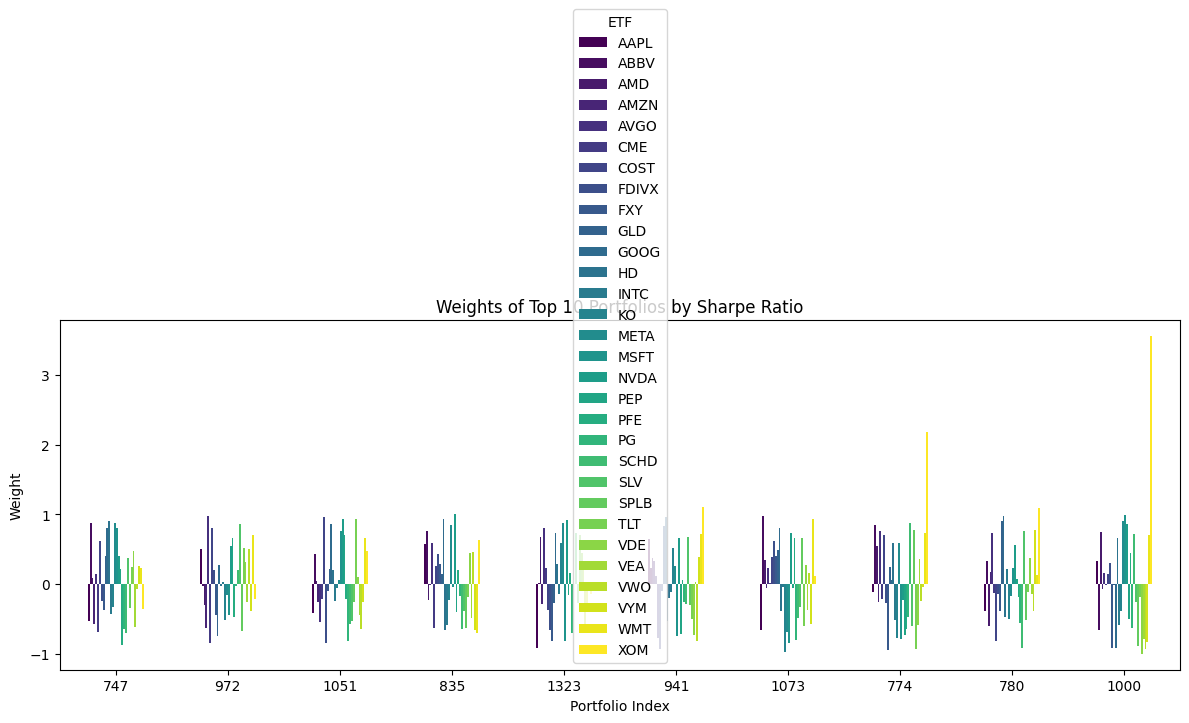

In [29]:
import matplotlib.pyplot as plt

top_10_portfolios = res2.sort_values(by="sharpe", ascending=False).head(10)

# Select only the weight columns
weights_df = top_10_portfolios[[col for col in res2.columns if col.startswith('w')]]

# Rename columns for better plotting labels
weights_df.columns = [tickers[i] for i in range(len(weights_df.columns))]

# Plotting the weights
ax = weights_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.title('Weights of Top 10 Portfolios by Sharpe Ratio')
plt.xlabel('Portfolio Index')
plt.ylabel('Weight')
plt.xticks(rotation=0)
plt.legend(title='ETF')
plt.tight_layout()
plt.show()

In [30]:
# Assuming the 700 simulation periods represent 700 trading days
sim_periods = 1000
trading_days_in_year = 252

# Calculate annualized mean returns for each portfolio in res2
res2["mean_annualized_simulated"] = res2["mean"] * (trading_days_in_year / sim_periods)

print("Simulated Mean Returns (over 700 periods) vs. Annualized Simulated Mean Returns:")
display(res2[["mean", "mean_annualized_simulated"]].head())

# Optionally, you can also display the top portfolios with their annualized simulated returns
print("\nTop 10 portfolios by  Annualized Simulated Mean Return:")
display(res2.sort_values(by="mean", ascending=False).head(10)[["w1", "w2", "w3", "w4", "mean", "mean_annualized_simulated", "sharpe"]])

Simulated Mean Returns (over 700 periods) vs. Annualized Simulated Mean Returns:


,mean,mean_annualized_simulated
0,0.157824,0.039772
1,0.160760,0.040511
2,0.158731,0.040000
3,0.173063,0.043612
4,0.168708,0.042514



Top 10 portfolios by  Annualized Simulated Mean Return:


,w1,w2,w3,w4,mean,mean_annualized_simulated,sharpe
1000,0.334783,-0.654965,0.750100,-0.072096,1.669944,0.420826,1.214568
789,0.614281,-0.886627,-0.173410,0.519405,1.591055,0.400946,0.999536
1032,-0.552762,0.273307,0.417495,-0.939612,1.544804,0.389291,0.879622
835,0.572706,0.757693,-0.223288,-0.004492,1.457982,0.367411,1.300898
732,-0.692296,-0.352923,0.410243,0.253531,1.399461,0.352664,0.958536
1176,-0.414756,0.153464,-0.051179,0.475953,1.363567,0.343619,0.949787
1201,-0.505290,-0.126094,0.750370,-0.657120,1.351418,0.340557,1.141295
984,-0.314804,0.589668,0.867170,0.677231,1.333976,0.336162,0.756013
1323,-0.917342,0.012735,0.673742,-0.276873,1.330925,0.335393,1.287704
724,-0.506173,-0.324195,0.775276,0.034241,1.268999,0.319788,0.689997


In [31]:
# Detect the points that make the Efficient Frontier for the Portfolio
efficient_frontier_portfolios_list = []

for i in range(len(res2)):
  is_on_frontier = True
  portfolio_to_check = res2.iloc[i]

  for j in range(len(res2)):
      if i != j:
          other_portfolio = res2.iloc[j]
          # Check if other_portfolio dominates portfolio_to_check
          if (other_portfolio["sd_sample"] <= portfolio_to_check["sd_sample"] and other_portfolio["mean"] > portfolio_to_check["mean"]) or \
            (other_portfolio["sd_sample"] < portfolio_to_check["sd_sample"] and other_portfolio["mean"] >= portfolio_to_check["mean"]):
              is_on_frontier = False
              break

  if is_on_frontier:
      # If on the frontier, add the portfolio (as a Series or dictionary) to the list
      efficient_frontier_portfolios_list.append(portfolio_to_check)
      #print(f"Portfolio at index {i} is on the simulated efficient frontier.")
  #else:
  #    print(f"Portfolio at index {i} is NOT on the simulated efficient frontier.")

# Convert the list of efficient frontier portfolios into a DataFrame
ef_frame = pd.DataFrame(efficient_frontier_portfolios_list)


print("Efficient Frontier Portfolios:")
display(ef_frame)


Efficient Frontier Portfolios:


,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,has_shorts,mean,sd_sample,sd_theoretical,sharpe,var_95,cvar_95,regime,scenario,mean_annualized_simulated
47,0.002128,0.061624,0.002338,0.003999,0.031631,0.018918,0.060697,0.028708,0.048027,0.027344,...,0,0.170849,0.161800,0.161800,1.055928,-0.103933,-0.177979,Long Positions Only,Personal ETF,0.043054
87,0.017213,0.045742,0.002843,0.016292,0.044749,0.036523,0.042000,0.049760,0.025558,0.046330,...,0,0.184560,0.170689,0.170689,1.081259,-0.103063,-0.174713,Long Positions Only,Personal ETF,0.046509
151,0.011693,0.048707,0.036272,0.056594,0.033800,0.006785,0.011523,0.017003,0.066520,0.022258,...,0,0.149144,0.152777,0.152777,0.976221,-0.101828,-0.169128,Long Positions Only,Personal ETF,0.037584
290,0.048181,0.012454,0.063172,0.033494,0.041695,0.035689,0.041147,0.046898,0.003065,0.035820,...,0,0.226032,0.204988,0.204988,1.102659,-0.132092,-0.196765,Long Positions Only,Personal ETF,0.056960
307,0.013125,0.038250,0.058675,0.017568,0.015938,0.029909,0.047736,0.050695,0.046626,0.053933,...,0,0.196479,0.173235,0.173235,1.134173,-0.098751,-0.164409,Long Positions Only,Personal ETF,0.049513
308,0.037005,0.034337,0.036605,0.017661,0.056270,0.013442,0.037435,0.013628,0.058473,0.052156,...,0,0.200948,0.179158,0.179158,1.121622,-0.105512,-0.173076,Long Positions Only,Personal ETF,0.050639
329,0.007347,0.042854,0.009883,0.051338,0.036008,0.051183,0.024219,0.042158,0.042557,0.055290,...,0,0.178016,0.163009,0.163009,1.092058,-0.094466,-0.168951,Long Positions Only,Personal ETF,0.044860
379,0.020586,0.067020,0.052955,0.040112,0.047402,0.035975,0.064488,0.005214,0.003162,0.020497,...,0,0.207177,0.183664,0.183664,1.128019,-0.101413,-0.173703,Long Positions Only,Personal ETF,0.052208
381,0.008715,0.011747,0.034661,0.064671,0.058662,0.044841,0.036814,0.018563,0.029576,0.035927,...,0,0.184569,0.172196,0.172196,1.071856,-0.099188,-0.175138,Long Positions Only,Personal ETF,0.046512
410,0.034269,0.057067,0.003427,0.043191,0.051810,0.069461,0.003388,0.055810,0.038845,0.060885,...,0,0.212912,0.184393,0.184393,1.154668,-0.097138,-0.176932,Long Positions Only,Personal ETF,0.053654


In [32]:
# Verify pareto_weights
print("=" * 80)
print("PARETO WEIGHTS VERIFICATION")
print("=" * 80)
print(f"Number of tickers: {len(tickers)}")
print(f"Number of pareto_weights: {len(pareto_weights)}")
print(f"Sum of pareto_weights: {sum(pareto_weights):.6f}")
print(f"\nTickers and their Pareto weights:")
for ticker, weight in zip(tickers, pareto_weights):
    print(f"  {ticker:10s}: {weight:8.6f}")

# Run experiment WITH Pareto guidance
print("\n" + "=" * 80)
print("EXPERIMENT 1: Pareto-Guided Weight Sampling")
print("=" * 80)

res2_pareto, stats2_pareto = run_experiment(
    mu2, sd2, corr2,
    sample_size=700, 
    n_weights=700,
    seed_returns=2222, 
    seed_weights=8888,
    pareto_weights=pareto_weights,  # Use Pareto optimal weights as guidance
    use_pareto_guided=True,
    std_dev=0.05  # 5% standard deviation around each Pareto weight
)

res2_pareto["scenario"] = "Personal ETF (Pareto-Guided)"
print(f"✓ Generated {len(res2_pareto)} portfolios using Pareto-guided sampling")

# Run experiment WITHOUT Pareto guidance (original random sampling)
print("\n" + "=" * 80)
print("EXPERIMENT 2: Random Weight Sampling (Original)")
print("=" * 80)

res2_random, stats2_random = run_experiment(
    mu2, sd2, corr2,
    sample_size=700, 
    n_weights=700,
    seed_returns=2222, 
    seed_weights=8888,
    pareto_weights=None,  # No Pareto guidance
    use_pareto_guided=False
)

res2_random["scenario"] = "Personal ETF (Random)"
print(f"✓ Generated {len(res2_random)} portfolios using random sampling")

# Compare results
print("\n" + "=" * 80)
print("COMPARISON: Pareto-Guided vs Random Sampling")
print("=" * 80)

comparison_results = pd.DataFrame({
    'Method': ['Pareto-Guided', 'Random'],
    'Max Sharpe Ratio': [
        res2_pareto['sharpe'].max(),
        res2_random['sharpe'].max()
    ],
    'Mean Sharpe Ratio': [
        res2_pareto['sharpe'].mean(),
        res2_random['sharpe'].mean()
    ],
    'Std Dev of Sharpe': [
        res2_pareto['sharpe'].std(),
        res2_random['sharpe'].std()
    ],
    'Min Sharpe Ratio': [
        res2_pareto['sharpe'].min(),
        res2_random['sharpe'].min()
    ]
})

display(comparison_results)

# Display top 5 portfolios from each method
print("\n📊 Top 5 Portfolios (Pareto-Guided):")
display(res2_pareto.sort_values(by="sharpe", ascending=False).head(5)[["sharpe", "mean", "sd_sample", "regime"]])

print("\n📊 Top 5 Portfolios (Random):")
display(res2_random.sort_values(by="sharpe", ascending=False).head(5)[["sharpe", "mean", "sd_sample", "regime"]])

PARETO WEIGHTS VERIFICATION
Number of tickers: 30
Number of pareto_weights: 30
Sum of pareto_weights: 1.000000

Tickers and their Pareto weights:
  AAPL      : 0.010123
  ABBV      : 0.011440
  AMD       : 0.000082
  AMZN      : 0.000048
  AVGO      : 0.010165
  CME       : 0.096002
  COST      : 0.010261
  FDIVX     : 0.100893
  FXY       : 0.000063
  GLD       : 0.000075
  GOOG      : 0.010755
  HD        : 0.013069
  INTC      : 0.010136
  KO        : 0.082796
  META      : 0.010174
  MSFT      : 0.010364
  NVDA      : 0.010144
  PEP       : 0.063657
  PFE       : 0.097801
  PG        : 0.010834
  SCHD      : 0.010161
  SLV       : 0.000015
  SPLB      : 0.100809
  TLT       : 0.087885
  VDE       : 0.010223
  VEA       : 0.010097
  VWO       : 0.010177
  VYM       : 0.100691
  WMT       : 0.010156
  XOM       : 0.100903

EXPERIMENT 1: Pareto-Guided Weight Sampling
Input 1: SD array:
 [0.32183268 0.24962663 0.53897213 0.35734031 0.43644613 0.26898026
 0.23906935 0.19642579 0.1001943

,Method,Max Sharpe Ratio,Mean Sharpe Ratio,Std Dev of Sharpe,Min Sharpe Ratio
0,Pareto-Guided,1.240309,0.666723,0.284113,-1.022338
1,Random,1.481604,0.566797,0.539268,-1.297903



📊 Top 5 Portfolios (Pareto-Guided):


,sharpe,mean,sd_sample,regime
834,1.240309,0.197652,0.159357,Shorts OK
900,1.225442,0.196677,0.160495,Shorts OK
883,1.213383,0.202073,0.166537,Shorts OK
134,1.176117,0.185891,0.158055,Long Positions Only
1201,1.167775,0.219614,0.188062,Shorts OK



📊 Top 5 Portfolios (Random):


,sharpe,mean,sd_sample,regime
747,1.481604,1.246659,0.841425,Shorts OK
972,1.408337,1.033468,0.733821,Shorts OK
1051,1.372240,0.873113,0.636269,Shorts OK
835,1.300898,1.457982,1.120751,Shorts OK
1323,1.287704,1.330925,1.033564,Shorts OK


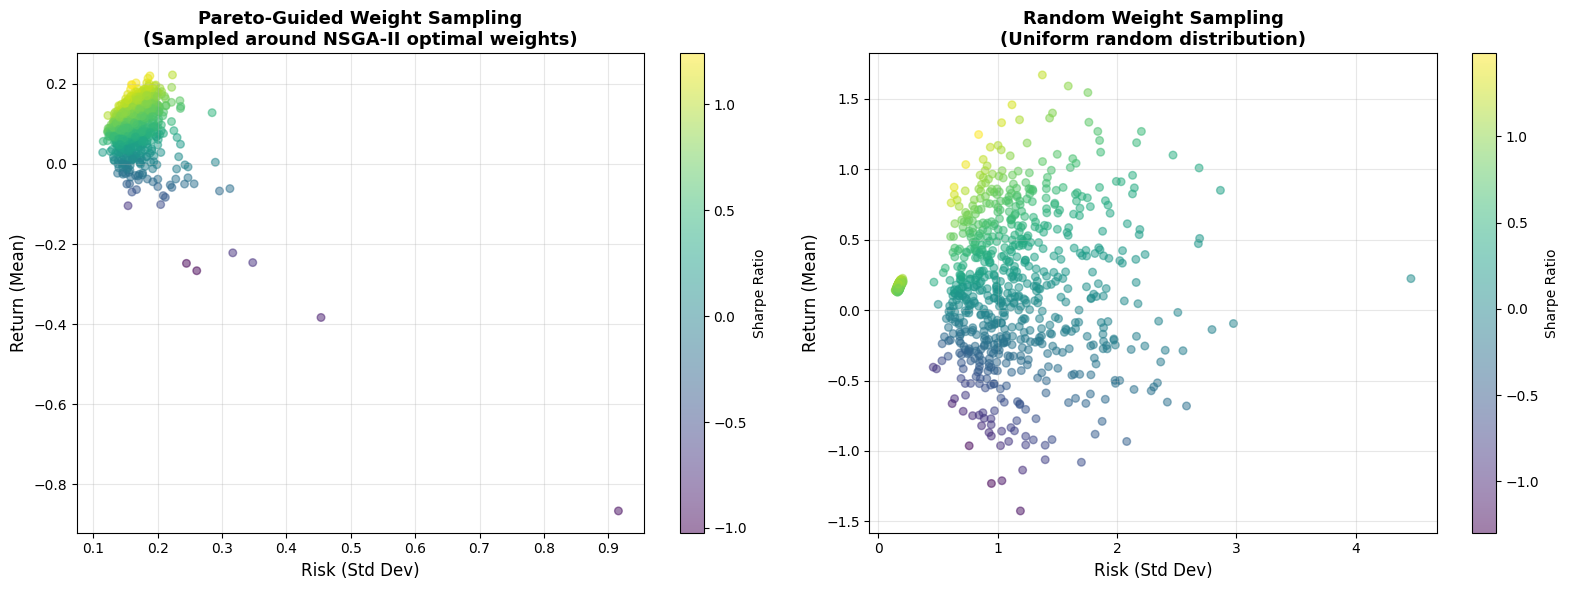

In [33]:
# Plot comparison of both methods
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pareto-guided
scatter1 = axes[0].scatter(res2_pareto["sd_sample"], res2_pareto["mean"], 
                          alpha=0.5, c=res2_pareto["sharpe"], cmap='viridis', s=30)
axes[0].set_xlabel("Risk (Std Dev)", fontsize=12)
axes[0].set_ylabel("Return (Mean)", fontsize=12)
axes[0].set_title("Pareto-Guided Weight Sampling\n(Sampled around NSGA-II optimal weights)", fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Sharpe Ratio')

# Random
scatter2 = axes[1].scatter(res2_random["sd_sample"], res2_random["mean"], 
                          alpha=0.5, c=res2_random["sharpe"], cmap='viridis', s=30)
axes[1].set_xlabel("Risk (Std Dev)", fontsize=12)
axes[1].set_ylabel("Return (Mean)", fontsize=12)
axes[1].set_title("Random Weight Sampling\n(Uniform random distribution)", fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Sharpe Ratio')

plt.tight_layout()
plt.savefig("pareto_vs_random_sampling_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# choose the pareto guided results  with the highest Sharpe ratio
best_pareto_portfolio = res2_pareto.loc[res2_pareto['sharpe'].idxmax()]
print("Best Pareto-Guided Portfolio by Sharpe Ratio:")
print(best_pareto_portfolio)

Best Pareto-Guided Portfolio by Sharpe Ratio:
w1                                   -0.010734
w2                                   -0.022056
w3                                   -0.014256
w4                                   -0.042164
w5                                    0.060094
w6                                    0.188657
w7                                    0.010967
w8                                    0.071054
w9                                    0.024713
w10                                   0.152093
w11                                  -0.005845
w12                                  -0.041999
w13                                  -0.087379
w14                                   0.114986
w15                                  -0.015571
w16                                   0.053167
w17                                   0.130594
w18                                   0.127653
w19                                  -0.005721
w20                                  -0.040762
w21           

In [36]:
# Find the portfolio with the highest Sharpe Ratio in each method and regime
# Pareto-guided portfolios
highest_sharpe_pareto_long = res2_pareto[res2_pareto["regime"] == "Long Positions Only"].loc[
    res2_pareto[res2_pareto["regime"] == "Long Positions Only"]["sharpe"].idxmax()
]
highest_sharpe_pareto_shorts = res2_pareto[res2_pareto["regime"] == "Shorts OK"].loc[
    res2_pareto[res2_pareto["regime"] == "Shorts OK"]["sharpe"].idxmax()
]

# Random portfolios
highest_sharpe_random_long = res2_random[res2_random["regime"] == "Long Positions Only"].loc[
    res2_random[res2_random["regime"] == "Long Positions Only"]["sharpe"].idxmax()
]
highest_sharpe_random_shorts = res2_random[res2_random["regime"] == "Shorts OK"].loc[
    res2_random[res2_random["regime"] == "Shorts OK"]["sharpe"].idxmax()
]

# Get weight columns dynamically
weight_cols = [col for col in res2_pareto.columns if col.startswith('w')]
n_weights = len(weight_cols)

# Create comparison DataFrame with all four portfolios
comparison_df = pd.DataFrame([
    highest_sharpe_pareto_long[weight_cols],
    highest_sharpe_pareto_shorts[weight_cols],
    highest_sharpe_random_long[weight_cols],
    highest_sharpe_random_shorts[weight_cols]
])

comparison_df.index = [
    "Pareto-Guided (Long Only)", 
    "Pareto-Guided (Shorts OK)",
    "Random (Long Only)",
    "Random (Shorts OK)"
]

# Use actual ticker names for columns
comparison_df.columns = [tickers[i] for i in range(min(len(tickers), n_weights))]

print("\n" + "=" * 80)
print("COMPARISON OF HIGHEST SHARPE RATIO PORTFOLIOS")
print("=" * 80)
display(comparison_df)

# Add performance metrics
performance_comparison = pd.DataFrame({
    'Method': [
        "Pareto-Guided (Long Only)", 
        "Pareto-Guided (Shorts OK)",
        "Random (Long Only)",
        "Random (Shorts OK)"
    ],
    'Sharpe Ratio': [
        highest_sharpe_pareto_long["sharpe"],
        highest_sharpe_pareto_shorts["sharpe"],
        highest_sharpe_random_long["sharpe"],
        highest_sharpe_random_shorts["sharpe"]
    ],
    'Mean Return': [
        highest_sharpe_pareto_long["mean"],
        highest_sharpe_pareto_shorts["mean"],
        highest_sharpe_random_long["mean"],
        highest_sharpe_random_shorts["mean"]
    ],
    'Std Dev': [
        highest_sharpe_pareto_long["sd_sample"],
        highest_sharpe_pareto_shorts["sd_sample"],
        highest_sharpe_random_long["sd_sample"],
        highest_sharpe_random_shorts["sd_sample"]
    ],
    'VaR (95%)': [
        highest_sharpe_pareto_long["var_95"],
        highest_sharpe_pareto_shorts["var_95"],
        highest_sharpe_random_long["var_95"],
        highest_sharpe_random_shorts["var_95"]
    ],
    'CVaR (95%)': [
        highest_sharpe_pareto_long["cvar_95"],
        highest_sharpe_pareto_shorts["cvar_95"],
        highest_sharpe_random_long["cvar_95"],
        highest_sharpe_random_shorts["cvar_95"]
    ]
})

print("\n" + "=" * 80)
print("PERFORMANCE METRICS COMPARISON")
print("=" * 80)
display(performance_comparison)

# Save both DataFrames
comparison_df.transpose().to_csv("highest_sharpe_portfolio_weights_comparison.csv", index=True)
performance_comparison.to_csv("highest_sharpe_portfolio_performance_comparison.csv", index=False)

print("\n✓ Saved comparison files:")
print("  - highest_sharpe_portfolio_weights_comparison.csv")
print("  - highest_sharpe_portfolio_performance_comparison.csv")


COMPARISON OF HIGHEST SHARPE RATIO PORTFOLIOS


,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,...,SCHD,SLV,SPLB,TLT,VDE,VEA,VWO,VYM,WMT,XOM
Pareto-Guided (Long Only),0.000000,0.000000,0.000000,0.000000,0.044315,0.139121,0.008087,0.052398,0.018224,0.112158,...,0.019413,0.059814,0.065094,0.051967,0.019432,0.009002,0.005553,0.012485,0.000000,0.068496
Pareto-Guided (Shorts OK),-0.010734,-0.022056,-0.014256,-0.042164,0.060094,0.188657,0.010967,0.071054,0.024713,0.152093,...,0.026326,0.081111,0.088271,0.070470,0.026350,0.012207,0.007530,0.016931,-0.069572,0.092885
Random (Long Only),0.034269,0.057067,0.003427,0.043191,0.051810,0.069461,0.003388,0.055810,0.038845,0.060885,...,0.000536,0.020113,0.027273,0.008735,0.023209,0.008876,0.026523,0.002643,0.047310,0.014840
Random (Shorts OK),-0.531499,0.875178,0.094141,-0.565186,0.145389,-0.680083,0.624449,-0.245971,-0.371348,0.404292,...,-0.703684,0.373841,-0.344500,0.246228,0.474470,-0.613253,-0.065391,0.262959,0.233568,-0.356058



PERFORMANCE METRICS COMPARISON


,Method,Sharpe Ratio,Mean Return,Std Dev,VaR (95%),CVaR (95%)
0,Pareto-Guided (Long Only),1.176117,0.185891,0.158055,-0.065137,-0.147241
1,Pareto-Guided (Shorts OK),1.240309,0.197652,0.159357,-0.053530,-0.134780
2,Random (Long Only),1.154668,0.212912,0.184393,-0.097138,-0.176932
3,Random (Shorts OK),1.481604,1.246659,0.841425,-0.193808,-0.451949



✓ Saved comparison files:
  - highest_sharpe_portfolio_weights_comparison.csv
  - highest_sharpe_portfolio_performance_comparison.csv
